In [1]:
from yahoo_fin.stock_info import get_data
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.graph_objects as go


Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [2]:
import ccxt
import pandas as pd
def timestamp_a_fecha(timestamp):
    # Dividir el timestamp por 1000 para convertirlo a segundos
    timestamp_segundos = timestamp / 1000
    # Convertir el timestamp a una fecha legible utilizando datetime
    fecha = datetime.utcfromtimestamp(timestamp_segundos).strftime('%Y-%m-%d %H:%M:%S')
    return fecha

exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1d'  # Intervalo de tiempo diario
limit = 1000  # Cantidad de datos a obtener
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
data_list = []
for data in ohlcv:
    data_dict = {
        'date': timestamp_a_fecha(data[0]),
        'open': data[1],
        'high': data[2],
        'low': data[3],
        'close': data[4],
        'volume': data[5]
    }
    data_list.append(data_dict)

# Crear un DataFrame a partir de la lista de diccionarios
btc = pd.DataFrame(data_list)   

Los datos del bitcoin no estan disponible directamente desde la API de yahoo finance, por lo que se usa la libreria ccxt para importarlos. 
Al importarlos vienen en forma de multilista y se crea-llena un dataframe para manejar estos con mayor comodidad. 

In [3]:
btc.head

<bound method NDFrame.head of                     date      open      high       low     close        volume
0    2021-07-11 00:00:00  33502.87  34666.00  33306.47  34258.99  31572.647448
1    2021-07-12 00:00:00  34259.00  34678.43  32658.34  33086.63  48181.403762
2    2021-07-13 00:00:00  33086.94  33340.00  32202.25  32729.77  41126.361008
3    2021-07-14 00:00:00  32729.12  33114.03  31550.00  32820.02  46777.823484
4    2021-07-15 00:00:00  32820.03  33185.25  31133.00  31880.00  51639.576353
..                   ...       ...       ...       ...       ...           ...
995  2024-04-01 00:00:00  71280.00  71288.23  68062.86  69649.80  41445.320390
996  2024-04-02 00:00:00  69649.81  69674.23  64550.00  65463.99  71799.827930
997  2024-04-03 00:00:00  65463.99  66903.63  64493.07  65963.28  39887.217780
998  2024-04-04 00:00:00  65963.27  69309.91  65064.52  68487.79  41510.484530
999  2024-04-05 00:00:00  68487.80  68756.67  67760.93  67890.00   3091.303260

[1000 rows x 6 column

<Axes: xlabel='date', ylabel='close'>

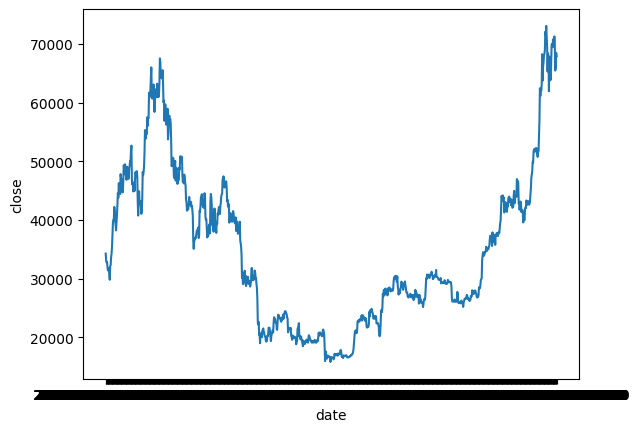

In [4]:
sns.lineplot(data=btc, x=btc.date, y=btc.close)

Para esta grafica solamente tomamos el precio de cierre y vemos como se mueve a traves del tiempo.

In [5]:
fig = go.Figure(data=[go.Candlestick(x = btc.date,
                                     open = btc.open, 
                                     high = btc.high,
                                     low = btc.low, 
                                     close = btc.close)
                     ])
fig.update_layout(
    title=" bitcoin/usdt",
    xaxis_title="Day",
    yaxis_title="BIT",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)
fig.update_layout(xaxis_rangeslider_visible=False)
fig

En este caso generamos la grafica de velas con frecuencias diarias con ayuda de plotly. 

In [6]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [7]:
result = adfuller(btc.close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.613042
p-value: 0.868008


Comenzanddo con el analisis, realizamos la preuba de dicky fuller. Obtenemos un p-valor(0.806), 
por tanto rechazamos la hipotesis nula y concluimos que la serie no es estacionaria.  


In [8]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

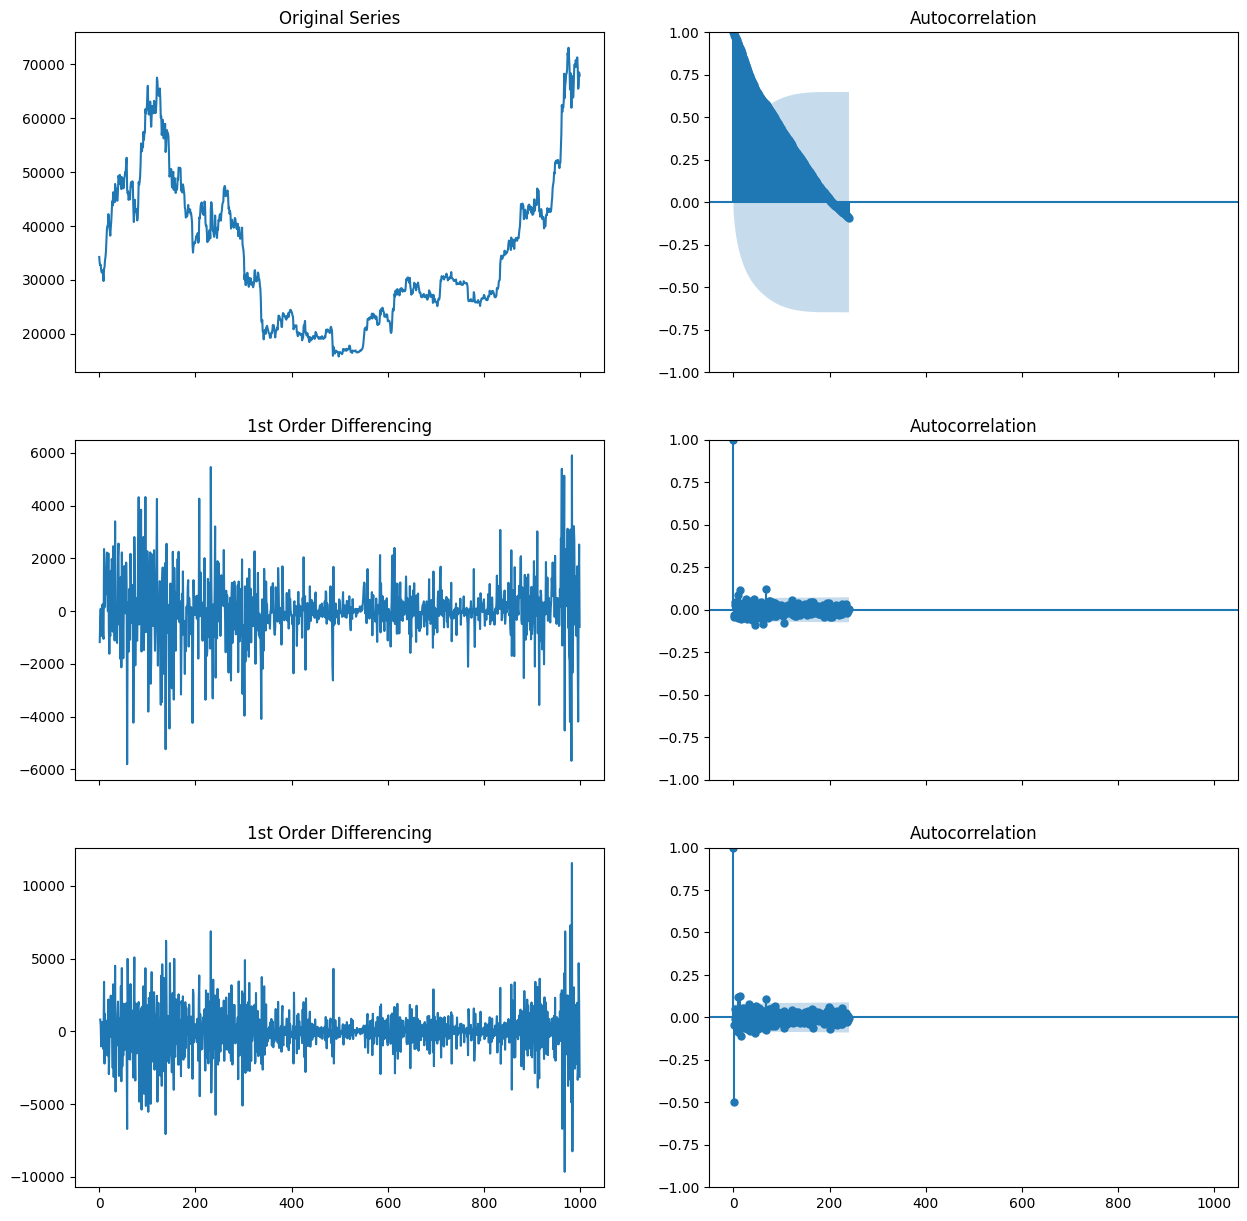

In [9]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(btc.close); axes[0, 0].set_title('Original Series')
plot_acf(btc.close, ax=axes[0, 1], lags = 240)
axes[1, 0].plot(btc.close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(btc.close.diff().dropna(), ax=axes[1, 1], lags = 240)
axes[2, 0].plot(btc.close.diff().diff()); axes[2, 0].set_title('1st Order Differencing')
plot_acf(btc.close.diff().diff().dropna(), ax=axes[2, 1], lags = 240)
plt.show()

Notamos que el decaimiento geometrico en la primera figura de autocorrelacion, que baja desde la parte 
positiva de forma lineal. lo dico se puede interpretar como una autocorrleacion asociada a una serie de tiempo no estacionaria.
Esto concuerda con lo concluido en la preuba de Dickyfuller.

modelo para horizonte = 14

In [10]:
n_btc = len(btc)

In [11]:

len_test_14 = 14
train_size_14 =n_btc - len_test_14 


In [12]:
train_14 = btc.close[:train_size_14]
dates_train_14 = btc.date[:train_size_14]
test_2w_14 = btc.close[train_size_14:train_size_14 + len_test_14] 
dates_2w_14 = btc.date[train_size_14:train_size_14 + len_test_14] 
print("train:", train_14.shape)
print("test_2w:", test_2w_14.shape)

train: (986,)
test_2w: (14,)


In [13]:
train_df_14 = btc[["close"]][:train_size_14]
test_2w_df_14 = btc[["close"]][train_size_14:train_size_14 + len_test_14] 

In [14]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
import numpy as np

In [15]:
def best_model(train):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    pq_rng = range(5)
    d_rng = range(3)

    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = ARIMA(train, order=(i, d, j)).fit()
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except:
                    continue

    return best_aic, best_order, best_mdl

In [16]:
import pmdarima as pm

def autoarima(train):
    model = pm.arima.auto_arima(train, start_p=1, start_q=1,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=3, max_q=3, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    return model

In [17]:
best_aic14, best_order14, best_md14 = best_model(train_14)

In [18]:
print(best_aic14)
print(best_order14) 
print(best_md14)

16707.951399339177
(3, 1, 3)


In [19]:
from statsmodels.graphics.tsaplots import plot_predict

In [20]:
model14 = ARIMA(train_14, order=best_order14)
model14_fit = model14.fit()

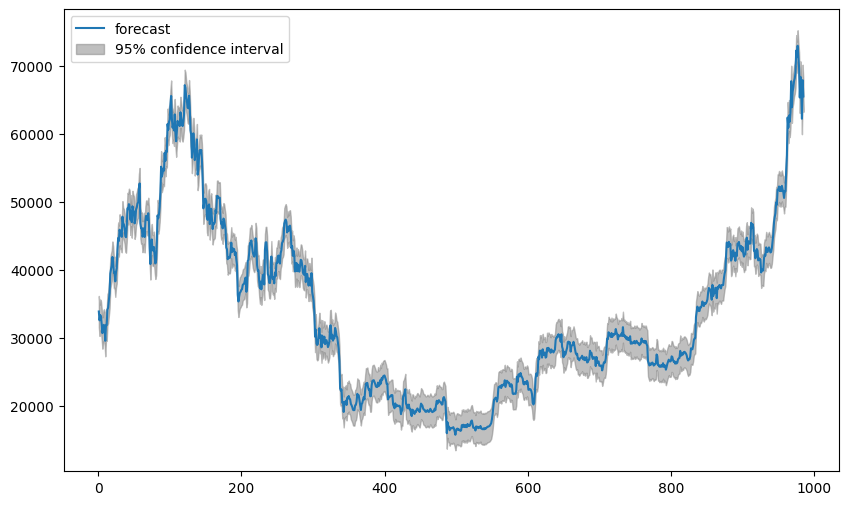

In [21]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots()

plot_predict(model14_fit, 1, ax=ax)
plt.show()

El primer modelo que tenemos resulta despues de encontrarlo segundo el criterio de akieke. Vemos que resulta un intervalo
de confianza bastante cerano a la serie, por lo que se puede preveer que el modelo tiene un buen ajuste. 

In [22]:
from sklearn.metrics import r2_score

In [23]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc

In [24]:
def arima_rolling(history, test, best_order):
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

In [25]:
print(best_order14)

(3, 1, 3)


In [26]:

yhat_2w_14 = arima_rolling((train_14.tolist()) , (test_2w_14).tolist(), best_order14)

predicted=63674.963310, expected=63990.010000
predicted=63968.922266, expected=67209.990000
predicted=67075.414991, expected=69880.010000
predicted=69699.437287, expected=69988.000000
predicted=69887.712868, expected=69469.990000
predicted=69364.237948, expected=70780.600000
predicted=70559.693783, expected=69850.540000
predicted=69718.933489, expected=69582.180000
predicted=69485.330285, expected=71280.010000
predicted=71330.399754, expected=69649.800000
predicted=69742.653972, expected=65463.990000
predicted=65529.495040, expected=65963.280000
predicted=66003.747774, expected=68487.790000
predicted=68480.420542, expected=67890.000000


In [27]:
forecast_accuracy(np.array(test_2w_14), np.array(yhat_2w_14), "ERROR")

,MAE,MSE,MAPE,RMSE,R2
ERROR,1470.81825,3.736747e+06,0.021685,1933.06674,0.132689


Analizando las metricas del modelo con un horizonte de 14 dias encontramos lo siguiente: 

+ MSE: Para el MSE tenememos un valor deseado de 3.39e+06, encontramos la media de los errores del modelos que se mueven alrededor
del 0. 

+ MAE: Tenemos la media de las diferencias absolutas entre las predicciones del modelo y los valores reales, igual
a 1443.17.

+ MAPE: vemos una precision relativa del modelo con respecto a los datos realesde 0.002. Partiendo del MSE, encontramos un RMSE 
acorde al modelo con un valor de 1842.64. 

+ r2: Se halla una correlacion leve de 0.41.

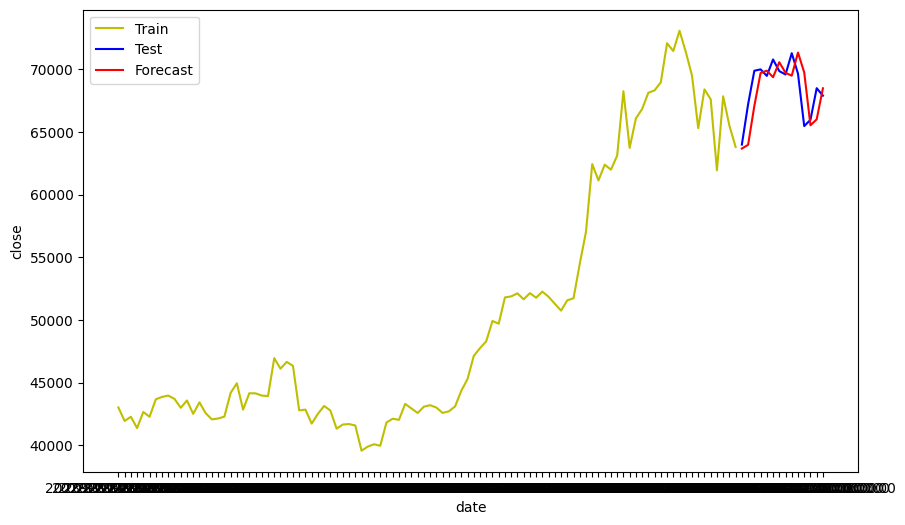

In [28]:
ax = sns.lineplot( x = dates_train_14[-100:], y=train_14[-100:], label="Train", color='y')
sns.lineplot( x = dates_2w_14, y=test_2w_14, label="Test", color='b')
sns.lineplot( x = dates_2w_14, y=yhat_2w_14, label="Forecast", color='r')

plt.show()

Para esta grafica apreciamos los resultados del forecast, los datos entrenados y los datos reales. Aprecimoas que 
la prediccion se ajusta bien a los datos reales que nos ofrece la serie de tiempopara los ultimos 14 dias. Ambas
partes mantienen la misma tendencia.   

Ahora realizamos un proceso parecido que se hizo, sin embargo, no aplicamos rolling. Por tanto, omitimos el llamdo
del rolling.

In [29]:
automodel14 = autoarima(train_14)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16714.706, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16713.563, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16712.949, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16712.837, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16712.212, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.392 seconds


In [30]:
print(automodel14)

 ARIMA(0,1,0)(0,0,0)[0]          


Hallamos un modelo de orden (p, d, q) (0, 1, 0) con un criterio de akaike igual a 16710.501, segun la funcion de auto-arima,
claro que tenemos en cuenta que esta funcion realiza el hallazgo del mejor modelo de una manera mas rapida, por lo que no 
tiene la misma rigurosidad que los distintos ciclos hallando el mejor criterio.

In [31]:
model_14_no_rolling =(ARIMA(train_14, order =(0,1,0))).fit()


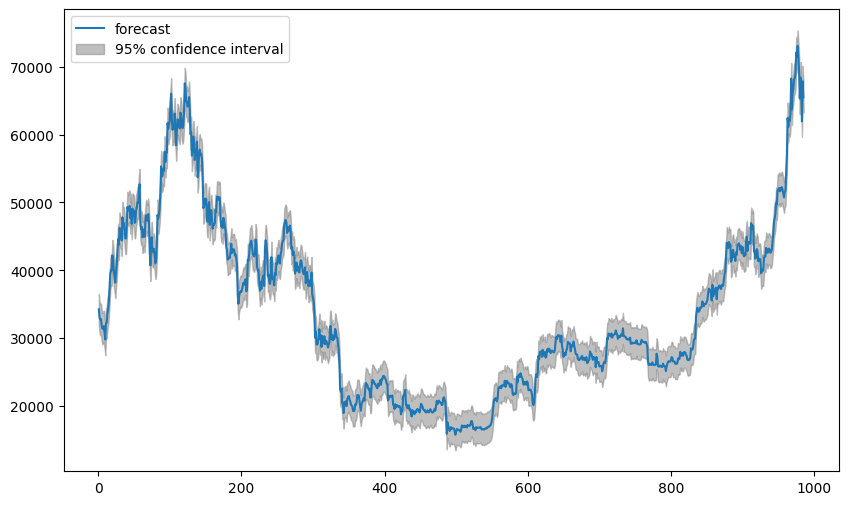

In [32]:

plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots()
plot_predict(model_14_no_rolling, 1, ax=ax)
plt.show()

Para el acercamiento que tenemos del modelo encontramos un intervalo cercano a lo que representa la serie 
de tiempo. 

In [33]:
forecast_14_no_rolling = model_14_no_rolling.forecast(steps=len(test_2w_14))

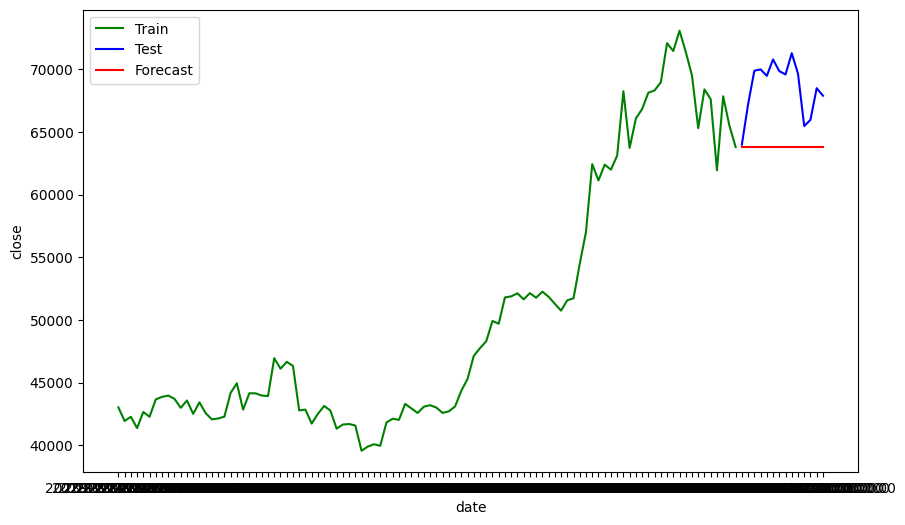

In [34]:

ax = sns.lineplot(x=dates_train_14[-100:], y=train_14[-100:], label="Train", color='g')
sns.lineplot(x=dates_2w_14, y=test_2w_14, label="Test", color='b')
sns.lineplot(x=dates_2w_14, y=forecast_14_no_rolling, label="Forecast", color='r')

# Mostrar el gráfico
plt.show()

Encontramos que sin rolling poco sentido cobra la prediccion. Los datos no toman ni la misma tendencia 
que los testeados. Valores constantes de la prediccion no van a cordes con la realidad del problema. 

Modelo para horizonte = 21

In [35]:
train_size_21 = len(btc) - 21

In [36]:

train_21 = btc.close[:train_size_21]
dates_train_21 = btc.date[:train_size_21]
test_2w_21 = btc.close[train_size_21:train_size_21 + 21] 
dates_2w_21 = btc.date[train_size_21:train_size_21 + 21] 
print("train:", train_21.shape)
print("test_2w:", test_2w_21.shape)

train: (979,)
test_2w: (21,)


In [37]:
train_df_21 = btc[["close"]][:train_size_21]
test_2w_df_21 = btc[["close"]][train_size_21:train_size_21 + 21] 

In [38]:
best_aic21, best_order21, best_md21 = best_model(train_21)

In [39]:
print(best_aic14)
print(best_order21)

16707.951399339177
(2, 1, 3)


Tomamos el los datos entrenados para un horizonte de 21 dias. Se encuentra un criterio de akaike de 16699.43.
El modelo posee un orden  de ( 2, 1, 3 ), tenemos un modelo que toma 2 observaciones de retraso, tiene un 
grado de diferenciacion y un tamaño de tres para la media movil. 

In [40]:
yhat_2w_21 = arima_rolling((train_21.tolist()) , (test_2w_21).tolist(), best_order21)

predicted=69521.850297, expected=65300.630000
predicted=65419.700791, expected=68393.480000
predicted=68396.518242, expected=67609.990000
predicted=67540.244417, expected=61937.400000
predicted=61993.936464, expected=67840.510000
predicted=67545.524132, expected=65501.270000
predicted=65778.184411, expected=63796.640000
predicted=63977.093814, expected=63990.010000
predicted=64117.613728, expected=67209.990000
predicted=67004.104622, expected=69880.010000
predicted=69875.649743, expected=69988.000000
predicted=70092.754818, expected=69469.990000
predicted=69677.149249, expected=70780.600000
predicted=70856.207599, expected=69850.540000
predicted=70037.127885, expected=69582.180000
predicted=69758.205938, expected=71280.010000
predicted=71336.991345, expected=69649.800000
predicted=69842.587705, expected=65463.990000
predicted=65792.486289, expected=65963.280000
predicted=66148.324609, expected=68487.790000
predicted=68203.813206, expected=67890.000000


In [41]:
forecast_accuracy(np.array(test_2w_21), np.array(yhat_2w_21), "ERROR")

,MAE,MSE,MAPE,RMSE,R2
ERROR,2054.704229,7.217430e+06,0.030687,2686.527546,-0.170787


En el caso del modelo con horioznte de 21 dias, encontramos los siguientes valores para las matericas:

+ MAE: Para la media de las diferencias de las predicciones con los valores reales renemos un valor
de 2128.92. 

+ MSE:  Un valor del error cuadratico medio de 2128.92, un valor un tanto mayor al hallado en 
el modelo con un horizonte de 14 dias. 

+ RMSE: La raiz cuadrado del MSE logra penalizar de mejor manera esos errores de mayor valor que cobra
el modelo. 

+ MAPE: Calculando la media de las diferencias entre el modelo y los valores reales en terminos porcentuales,
tenemos 2720.86. 

+ r2: la medida de bondad de ajuste de respuesta de los datos proporciona un valor negativo de -0.176. 

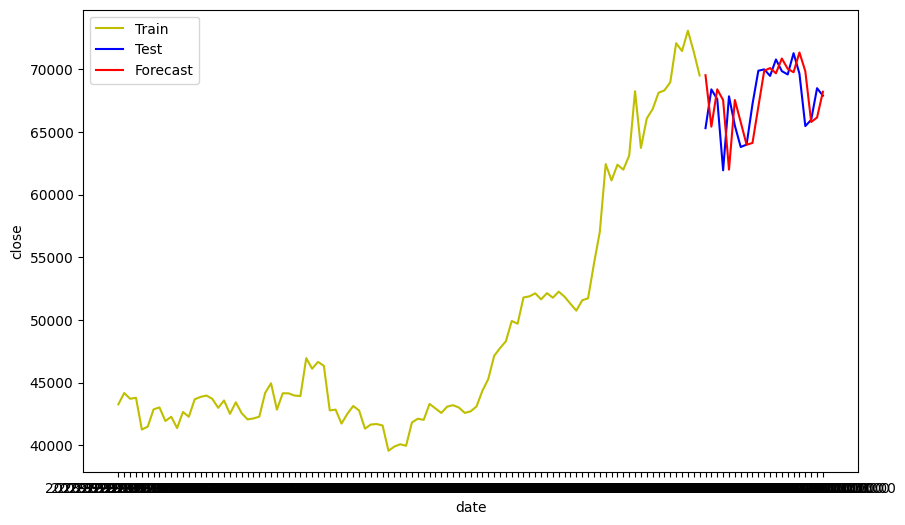

In [42]:
ax = sns.lineplot( x = dates_train_21[-100:], y=train_21[-100:], label="Train", color='y')
sns.lineplot( x = dates_2w_21, y=test_2w_21, label="Test", color='b')
sns.lineplot( x = dates_2w_21, y=yhat_2w_21, label="Forecast", color='r')

plt.show()

En este caso encontramos un modelo bien ajustado a los datos reales, se mantiene la misma tendencia
y comportamiento. Solamente encontramos, por decirlo de alguna forma, un retraso en el comportamiento
de la prediccion. 

In [43]:
mod21=(ARIMA(train_21, order =(2,1,3))).fit()

*Ahora se procede a realizar el modelo sin rolling para los 21 dias.*

In [44]:
automodel21 = autoarima(train_21)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16522.503, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16523.328, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16524.825, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16524.813, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16522.329, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.647 seconds


In [45]:
model_21_no_rolling =(ARIMA(train_21, order =(0,1,0))).fit()

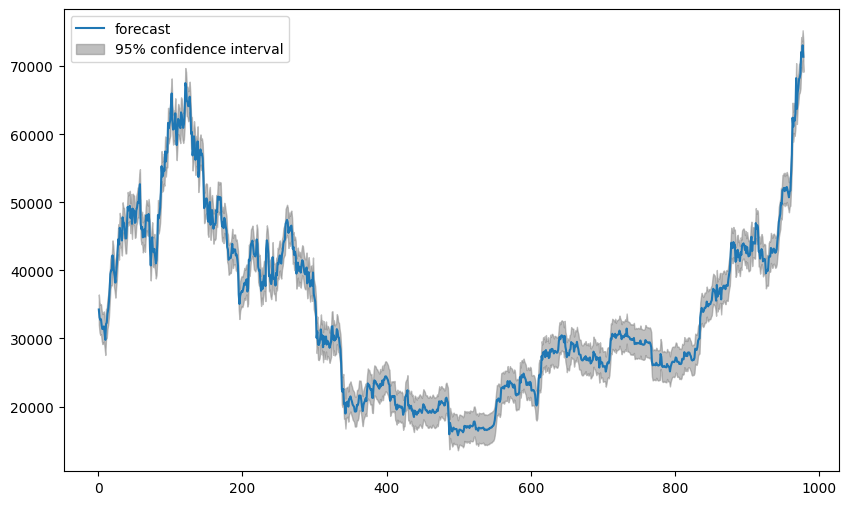

In [46]:

plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots()
plot_predict(model_21_no_rolling, 1, ax=ax)
plt.show()

Se aprecia un intervalo de confianza igual al hallado para el modelo sin rolling con el horizonte de los 14 dias. 
Lo que sucede gracias a que el modelo ARIMA brindado por autoarima de orden ( 0, 1, 0 ) .  

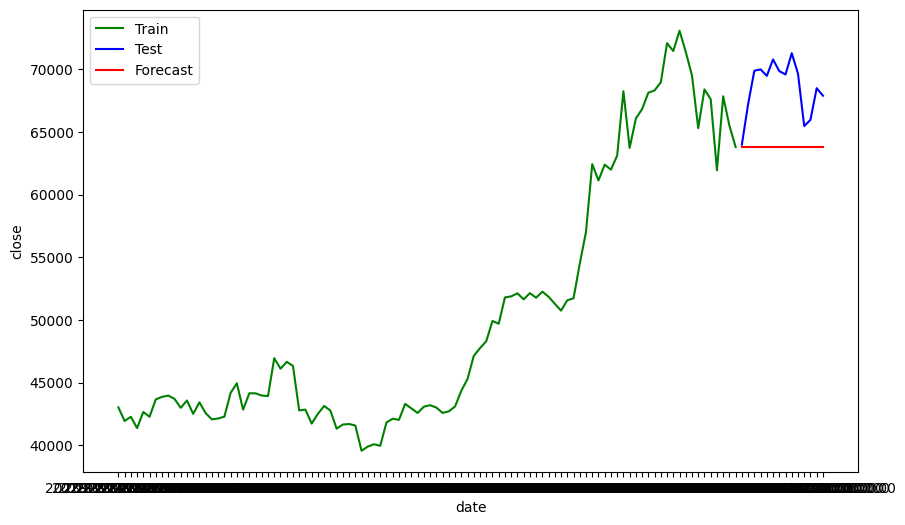

In [47]:
forecast_14_no_rolling = model_14_no_rolling.forecast(steps=len(test_2w_14))
ax = sns.lineplot(x=dates_train_14[-100:], y=train_14[-100:], label="Train", color='g')
sns.lineplot(x=dates_2w_14, y=test_2w_14, label="Test", color='b')
sns.lineplot(x=dates_2w_14, y=forecast_14_no_rolling, label="Forecast", color='r')

# Mostrar el gráfico
plt.show()

Teniendo den cuenta que solo toma un orden de diferenciacion cobra sentido que se genere una prediccion constante
para el modelo, la cual siguie sin ser acorde a la realidad del problema. 


Modelo para horzionte = 28

In [48]:
train_size_28 = len(btc) - 28
train_28 = btc.close[:train_size_28]
dates_train_28 = btc.date[:train_size_28]
test_2w_28 = btc.close[train_size_28:train_size_28 + 28] 
dates_2w_28 = btc.date[train_size_28:train_size_28 + 28] 
print("train:", train_28.shape)
print("test_2w:", test_2w_28.shape)

train: (972,)
test_2w: (28,)


In [49]:
best_aic28, best_order28, best_md28 = best_model(train_28)

In [50]:
print(best_aic28)
print(best_order28)

16393.94262497366
(3, 1, 2)


El mejor modelo posible nos arroja un criterio de akaike relativamente bajo, igual 16387. Para el order del
modelo tenemos que toma 2 observaciones de retraso, tiene un 
grado de diferenciacion y un tamaño de tres para la media movil.

In [51]:
yhat_2w_28 = arima_rolling((train_28.tolist()) , (test_2w_28).tolist(), best_order28)

predicted=68225.719276, expected=68313.270000
predicted=68587.717033, expected=68955.880000
predicted=69098.256152, expected=72078.100000
predicted=72308.745948, expected=71452.010000
predicted=71630.137816, expected=73072.410000
predicted=73407.503592, expected=71388.940000
predicted=71560.994377, expected=69499.850000
predicted=69912.015608, expected=65300.630000
predicted=65405.990236, expected=68393.480000
predicted=68546.863310, expected=67609.990000
predicted=67666.997599, expected=61937.400000
predicted=62367.061572, expected=67840.510000
predicted=67532.616173, expected=65501.270000
predicted=65803.107740, expected=63796.640000
predicted=63961.565832, expected=63990.010000
predicted=64109.178573, expected=67209.990000
predicted=67269.301256, expected=69880.010000
predicted=69897.040399, expected=69988.000000
predicted=70103.312282, expected=69469.990000
predicted=69672.809887, expected=70780.600000
predicted=70958.811139, expected=69850.540000
predicted=70035.846886, expected=6

In [52]:
forecast_accuracy(np.array(test_2w_28), np.array(yhat_2w_28), "ERROR")

,MAE,MSE,MAPE,RMSE,R2
ERROR,1904.481954,6.138940e+06,0.028065,2477.688452,0.130096


+ MAE (Error Absoluto Medio): El MAE indica que, en promedio, las predicciones del modelo están desviadas por aproximadamente 2128.92 unidades de la variable de interés respecto a los valores reales.

+ MSE (Error Cuadrático Medio): El MSE muestra que el modelo tiene un error cuadrático medio de 2128.92. Este valor indica que hay una considerable dispersión de los errores entre las predicciones y los valores reales.

+ RMSE (Raíz del Error Cuadrático Medio): El RMSE es la raíz cuadrada del MSE, y muestra que la raíz cuadrada de la dispersión de los errores es aproximadamente 2720.86. Como mencionaste, esta métrica ayuda a comprender la magnitud de los errores en la misma escala que los valores reales.

+ MAPE (Error Porcentual Absoluto Medio): El MAPE indica que, en promedio, las predicciones del modelo tienen una diferencia del 2.8638% en términos porcentuales respecto a los valores reales. Esto significa que las predicciones pueden desviarse aproximadamente en un 2.8638% de los valores reales.

+ R^2 (Coeficiente de Determinación): El valor negativo de -0.176 para el coeficiente de determinación (R^2) indica que el modelo no explica la variabilidad de los datos y proporciona un ajuste peor que simplemente usar la media de los valores reales como predicción. Esto sugiere que el modelo no se ajusta bien a los datos y puede que no esté capturando la estructura subyacente de la serie temporal de manera adecuada.

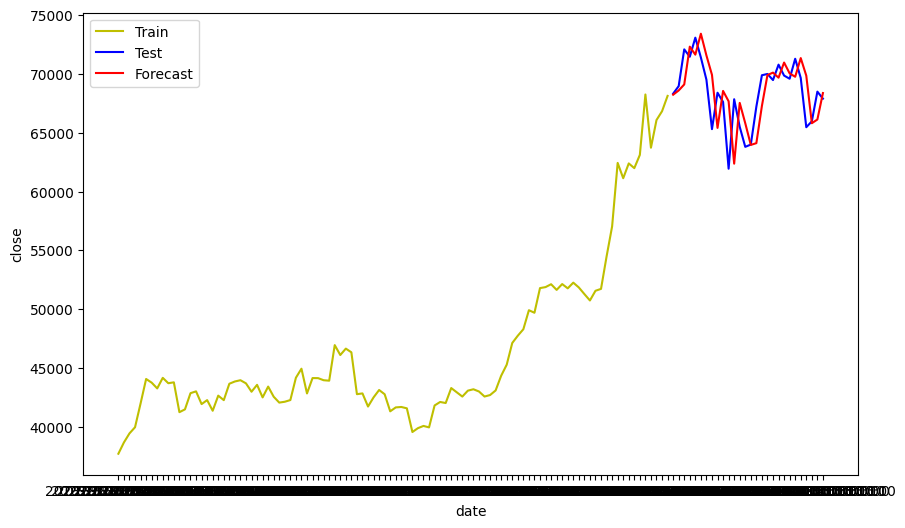

In [53]:
ax = sns.lineplot( x = dates_train_28[-100:], y=train_28[-100:], label="Train", color='y')
sns.lineplot( x = dates_2w_28, y=test_2w_28, label="Test", color='b')
sns.lineplot( x = dates_2w_28, y=yhat_2w_28, label="Forecast", color='r')

plt.show()

Para el test del forecast del modelo con horizonte de 28 dias, encontramos un modelo bien ajustado a los datos reales, se mantiene la misma tendencia
y comportamiento.

*Ahora se procede a realizar el modelo sin rolling para horizonte = 28*

In [54]:
automodel28 = autoarima(train_28)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16400.777, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16396.655, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16398.156, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16398.142, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16395.595, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.523 seconds


Apreciamos que el tercer modelo, hallado con auto arima, se comporta de la misma manera que los anteriores. 
se obtiene un modelo con un orden que solo tiene en cuenta un orden de diferenciacion. 




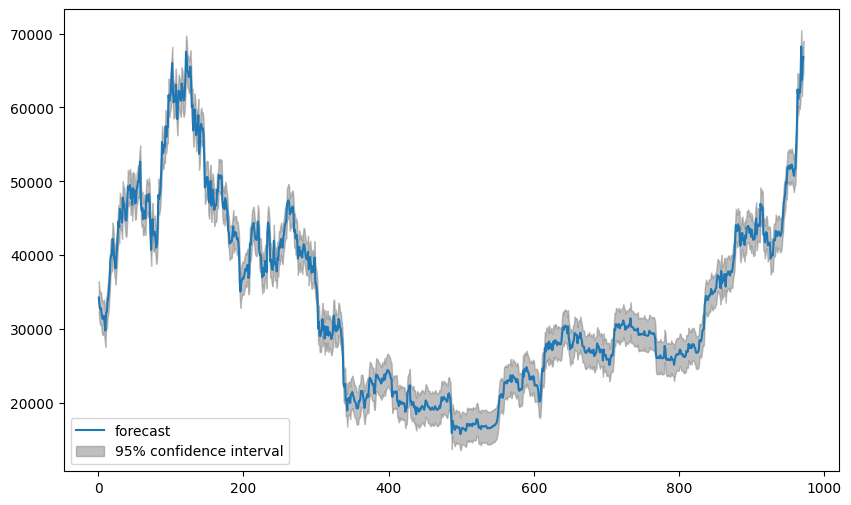

In [55]:
model_28_no_rolling =(ARIMA(train_28, order =(0,1,0))).fit()
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots()
plot_predict(model_28_no_rolling, 1, ax=ax)
plt.show()

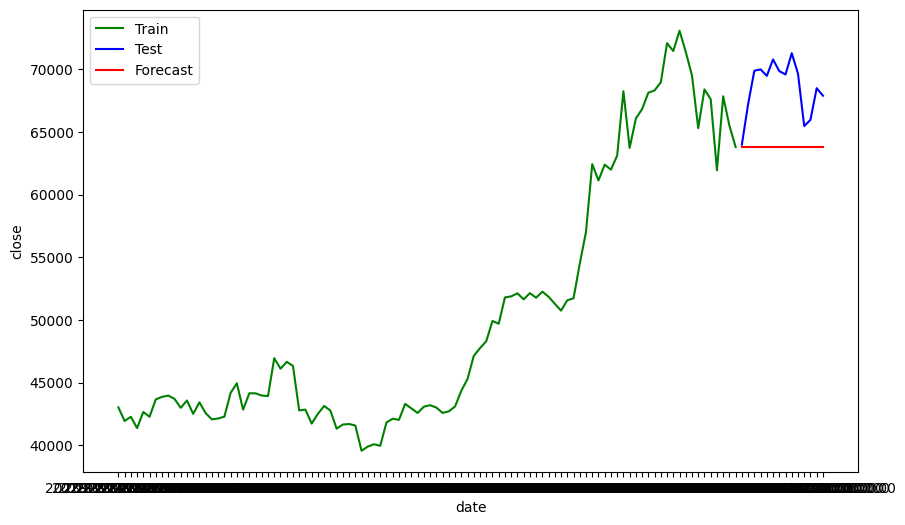

In [56]:
forecast_14_no_rolling = model_14_no_rolling.forecast(steps=len(test_2w_14))
ax = sns.lineplot(x=dates_train_14[-100:], y=train_14[-100:], label="Train", color='g')
sns.lineplot(x=dates_2w_14, y=test_2w_14, label="Test", color='b')
sns.lineplot(x=dates_2w_14, y=forecast_14_no_rolling, label="Forecast", color='r')

# Mostrar el gráfico
plt.show()

Finalmente encontramos lo mismo, para el modelo de no rolling con horizonte de 28 dias. No cobra sentido el omitir el
rolling para el proceso ARIMA.

Graficas de correlacion 

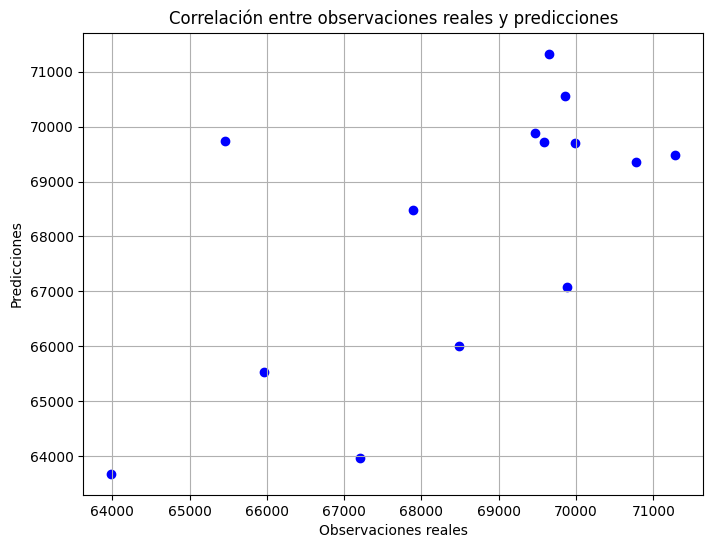

In [57]:
import matplotlib.pyplot as plt

# Graficar la correlación entre las predicciones y las observaciones reales
plt.figure(figsize=(8, 6))
plt.scatter(test_2w_14, yhat_2w_14, color='blue')
plt.xlabel('Observaciones reales')
plt.ylabel('Predicciones')
plt.title('Correlación entre observaciones reales y predicciones')
plt.grid(True)
plt.show()

Vemos que podria existir una diagonal que representa una correlacion buena. Sin embargo, 
los datos llegan a estar bastante dispersos. 

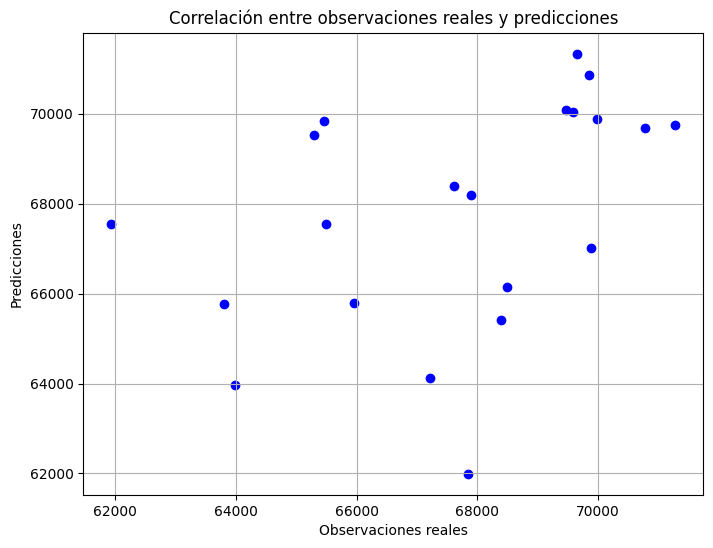

In [58]:
import matplotlib.pyplot as plt

# Graficar la correlación entre las predicciones y las observaciones reales
plt.figure(figsize=(8, 6))
plt.scatter(test_2w_21, yhat_2w_21, color='blue')
plt.xlabel('Observaciones reales')
plt.ylabel('Predicciones')
plt.title('Correlación entre observaciones reales y predicciones')
plt.grid(True)
plt.show()

Para la grafica de correalcion entre las predicciones del modelo con horizonte de 21 dias. Parece seguir con 
cierta inclinacion. Sin embargo, los datos se mantienen bastante dispersos.


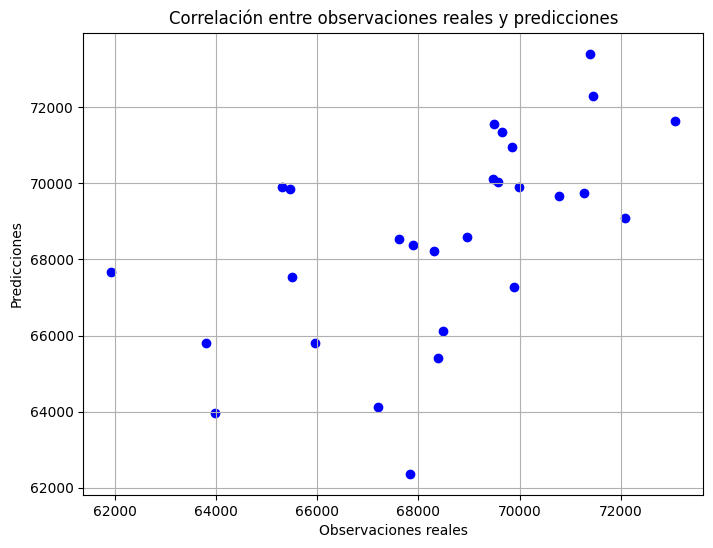

In [59]:
import matplotlib.pyplot as plt

# Graficar la correlación entre las predicciones y las observaciones reales
plt.figure(figsize=(8, 6))
plt.scatter(test_2w_28, yhat_2w_28, color='blue')
plt.xlabel('Observaciones reales')
plt.ylabel('Predicciones')
plt.title('Correlación entre observaciones reales y predicciones')
plt.grid(True)
plt.show()

Logramos ver que los dispersion es baja en los datos y que parece obtener correlacion postiva.

In [60]:
def best_model(train):
    best_aic = np.inf
    best_hqic = np.inf
    best_order = None
    best_mdl = None

    pq_rng = range(5)
    d_rng = range(3)

    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = ARIMA(train, order=(i, d, j)).fit()
                    tmp_aic = tmp_mdl.aic
                    tmp_hqic = tmp_mdl.hqic
                    if  tmp_hqic < best_hqic:
                        best_aic = tmp_aic
                        best_hqic = tmp_hqic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except:
                    continue

    return best_aic, best_hqic, best_order, best_mdl

In [61]:
par14 = best_model(train_14)

In [62]:
print(par14)

(16712.21230083063, 16714.073209658127, (0, 1, 0), <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001FF8307D790>)


In [63]:
print(best_model(train_21))

(16522.329035086914, 16524.187873398092, (0, 1, 0), <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001FF82DEE590>)


In [64]:
print(best_model(train_28))

(16395.594612446544, 16397.45136319948, (0, 1, 0), <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001FF82E16350>)


Hallamos el mejor modelo segun el HQIC, a diferencia de lo que haciamos antes, que era hallarlo segun el AIC.
Encontramos modelos que se comportan de la misma manera que los modelos que resultan de la funcion auto-arima, 
solo tienen en cuenta un orden de diferenciacion. Por tanto, la prediccion no tendra sentido al tomar valores constantes.
